In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from datetime import datetime, date
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from sklearn.metrics import r2_score

2024-10-24 18:53:04.264680: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 18:53:04.267130: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 18:53:04.274530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 18:53:04.287132: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 18:53:04.291405: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 18:53:04.302090: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# read data
data = pd.read_csv('/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/datasets/jrfm-2156907-cleaned.csv')
data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,Active Addr Cnt,Xfer Cnt,Mean Tx Size (native units),Total Fees (USD),...,RUB,Tweets,Google,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,2015-08-07,278.740997,280.391998,276.365997,279.584991,42484800.0,283150,497302,2.057514,7235.134845,...,64.480003,47467,90.000000,0,0,0,0,1,0,0
1,2015-08-08,279.742004,279.928009,260.709991,260.997009,58533000.0,266587,284532,3.675623,5806.842316,...,64.480003,29031,91.578947,0,0,0,0,0,1,0
2,2015-08-09,261.115997,267.002991,260.467987,265.083008,23789600.0,262571,276720,4.201519,4952.554125,...,64.480003,27132,91.578947,0,0,0,0,0,0,1
3,2015-08-10,265.477997,267.032013,262.596008,264.470001,20979400.0,292834,304538,3.463212,7563.840456,...,64.480003,27744,96.315789,1,0,0,0,0,0,0
4,2015-08-11,264.342010,270.385986,264.093994,270.385986,25433900.0,271613,280398,3.785274,7128.842169,...,62.889999,26653,104.210526,0,1,0,0,0,0,0


In [3]:
data.shape

(2430, 48)

In [4]:
data["Date"] = pd.to_datetime(data["Date"])

In [5]:
# Split data into 2 periods
start_day_p1 = pd.Timestamp(2015, 8, 7)
test_day_p1 = pd.Timestamp(2018, 4, 1)
end_day_p1 = pd.Timestamp(2018, 9, 30)

period1 = data[(data["Date"] >= start_day_p1) & (data["Date"] <= end_day_p1) ].reset_index(drop = True)
train_dataset_p1 = period1[period1["Date"] < test_day_p1].reset_index(drop = True)
test_dataset_p1 = period1[period1["Date"] >= test_day_p1].reset_index(drop = True)


start_day_p2 = pd.Timestamp(2018, 10, 1)
test_day_p2 = pd.Timestamp(2021, 10, 1)
end_day_p2 = pd.Timestamp(2022, 4, 1)

period2 = data[(data["Date"] >= start_day_p2) & (data["Date"] <= end_day_p2) ].reset_index(drop = True)
train_dataset_p2 = period2[period2["Date"] < test_day_p2].reset_index(drop = True)
test_dataset_p2 = period2[period2["Date"] >= test_day_p2].reset_index(drop = True)

train_dataset_p1 = train_dataset_p1.drop("Date", axis=1)
test_dataset_p1 = test_dataset_p1.drop("Date", axis=1)
train_dataset_p2 = train_dataset_p2.drop("Date", axis=1)
test_dataset_p2 = test_dataset_p2.drop("Date", axis=1)


print(period1.shape, period2.shape)

(1151, 48) (1279, 48)


In [6]:
# Metrics
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score

def directional_accuracy(y_true, y_pred):
	y_test_da = np.array(y_true)
	y_pred_0 = y_pred[1:] - y_test_da[:-1]
	y_test_0 = y_true[1:] - y_test_da[:-1]
	DA = (y_pred_0<0) == (y_test_0<0)
	return np.mean(DA)*100
# Scaler
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor


def create_data_RF(train_dataset, test_dataset):
	X_train = train_dataset[:-1]
	Y_train = train_dataset["BTC_Close"][1:]
	X_test = test_dataset[:-1]
	Y_test = test_dataset["BTC_Close"][1:]
	return X_train, Y_train, X_test, Y_test


def train_model_RF(X_train, Y_train, X_test):
	rfr = RandomForestRegressor(max_depth=10, n_estimators=500)
	rfr.fit(X_train, Y_train)
	pred_y = rfr.predict(X_test)
	return pred_y

# LSTM
def create_data_LSTM(train_dataset, test_dataset, scaled=True, time_step=1):
	def create_sequences(data, target, time_step):
		X, y = [], []
		for i in range(len(data) - time_step):
			X.append(data[i:(i + time_step)])
			y.append(target[i + time_step])
		return np.array(X), np.array(y)

	X_train = train_dataset
	Y_train = train_dataset["BTC_Close"]
	X_test = test_dataset
	Y_test = test_dataset["BTC_Close"]
	X_train, Y_train = create_sequences(X_train, Y_train, time_step=time_step)
	X_test, Y_test = create_sequences(X_test, Y_test, time_step=time_step)
	if (scaled == True):
		scaler = MinMaxScaler()
		X_train_scaled = scaler.fit_transform(
			X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
		X_test_scaled = scaler.transform(
			X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
		X_train = X_train_scaled
		X_test = X_test_scaled

	return X_train, Y_train, X_test, Y_test

from tensorflow.keras.callbacks import EarlyStopping # type: ignore
def train_model_lstm(X_train, Y_train, X_test, epochs=250):
	model = tf.keras.Sequential([
		tf.keras.layers.LSTM(128, activation='relu', input_shape=(
			X_train.shape[1], X_train.shape[2]), return_sequences=True),
		tf.keras.layers.Dropout(0.2),
		tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
		tf.keras.layers.Dropout(0.3),
		tf.keras.layers.LSTM(256, activation='relu', return_sequences=True),
		tf.keras.layers.Dropout(0.4),
		tf.keras.layers.LSTM(256, activation='relu', return_sequences=False),
		tf.keras.layers.Dropout(0.5),
		tf.keras.layers.Dense(1)
	])
	model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
	early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
	history = model.fit(X_train, Y_train, epochs=epochs)
	prediction = model.predict(X_test)
	return prediction

In [8]:
# Create data
## Random Forest
X_train_RF_p1, Y_train_RF_p1, X_test_RF_p1, Y_test_RF_p1 = create_data_RF(train_dataset_p1, test_dataset_p1)
## LSTM
X_train_LSTM_l1_p1, Y_train_LSTM_l1_p1, X_test_LSTM_l1_p1, Y_test_LSTM_l1_p1 = create_data_LSTM(train_dataset_p1, test_dataset_p1, True, 1)
X_train_LSTM_l3_p1, Y_train_LSTM_l3_p1, X_test_LSTM_l3_p1, Y_test_LSTM_l3_p1 = create_data_LSTM(train_dataset_p1, test_dataset_p1, True, 3)
X_train_LSTM_l7_p1, Y_train_LSTM_l7_p1, X_test_LSTM_l7_p1, Y_test_LSTM_l7_p1 = create_data_LSTM(train_dataset_p1, test_dataset_p1, True, 7)
X_train_LSTM_l14_p1, Y_train_LSTM_l14_p1, X_test_LSTM_l14_p1, Y_test_LSTM_l14_p1 = create_data_LSTM(train_dataset_p1, test_dataset_p1, True, 14)

## Random Forest
X_train_RF_p2, Y_train_RF_p2, X_test_RF_p2, Y_test_RF_p2 = create_data_RF(train_dataset_p2, test_dataset_p2)
## LSTM
X_train_LSTM_l1_p2, Y_train_LSTM_l1_p2, X_test_LSTM_l1_p2, Y_test_LSTM_l1_p2 = create_data_LSTM(train_dataset_p2, test_dataset_p2, True, 1)
X_train_LSTM_l3_p2, Y_train_LSTM_l3_p2, X_test_LSTM_l3_p2, Y_test_LSTM_l3_p2 = create_data_LSTM(train_dataset_p2, test_dataset_p2, True, 3)
X_train_LSTM_l7_p2, Y_train_LSTM_l7_p2, X_test_LSTM_l7_p2, Y_test_LSTM_l7_p2 = create_data_LSTM(train_dataset_p2, test_dataset_p2, True, 7)
X_train_LSTM_l14_p2, Y_train_LSTM_l14_p2, X_test_LSTM_l14_p2, Y_test_LSTM_l14_p2 = create_data_LSTM(train_dataset_p2, test_dataset_p2, True, 14)

In [9]:
RF_p1_results = []
LSTM_l1_p1_results = []
LSTM_l3_p1_results = []
LSTM_l7_p1_results = []
LSTM_l14_p1_results = []
RF_p2_results = []
LSTM_l1_p2_results = []
LSTM_l3_p2_results = []
LSTM_l7_p2_results = []
LSTM_l14_p2_results = []

for i in range(1):
	rf_p1_result = train_model_RF(X_train_RF_p1, Y_train_RF_p1, X_test_RF_p1)
	lstm_l1_p1_result = train_model_lstm(X_train_LSTM_l1_p1, Y_train_LSTM_l1_p1, X_test_LSTM_l1_p1)
	lstm_l3_p1_result = train_model_lstm(X_train_LSTM_l3_p1, Y_train_LSTM_l3_p1, X_test_LSTM_l3_p1)
	lstm_l7_p1_result = train_model_lstm(X_train_LSTM_l7_p1, Y_train_LSTM_l7_p1, X_test_LSTM_l7_p1)
	lstm_l14_p1_result = train_model_lstm(X_train_LSTM_l14_p1, Y_train_LSTM_l14_p1, X_test_LSTM_l14_p1)
	rf_p2_result = train_model_RF(X_train_RF_p2, Y_train_RF_p2, X_test_RF_p2)
	lstm_l1_p2_result = train_model_lstm(X_train_LSTM_l1_p2, Y_train_LSTM_l1_p2, X_test_LSTM_l1_p2, epochs=70)
	lstm_l3_p2_result = train_model_lstm(X_train_LSTM_l3_p2, Y_train_LSTM_l3_p2, X_test_LSTM_l3_p2, epochs=70)
	lstm_l7_p2_result = train_model_lstm(X_train_LSTM_l7_p2, Y_train_LSTM_l7_p2, X_test_LSTM_l7_p2, epochs=70)
	lstm_l14_p2_result = train_model_lstm(X_train_LSTM_l14_p2, Y_train_LSTM_l14_p2, X_test_LSTM_l14_p2, epochs=70)

	RF_p1_results.append(rf_p1_result)
	LSTM_l1_p1_results.append(lstm_l1_p1_result)
	LSTM_l3_p1_results.append(lstm_l3_p1_result)
	LSTM_l7_p1_results.append(lstm_l7_p1_result)
	LSTM_l14_p1_results.append(lstm_l14_p1_result)

	RF_p2_results.append(rf_p2_result)
	LSTM_l1_p2_results.append(lstm_l1_p2_result)
	LSTM_l3_p2_results.append(lstm_l3_p2_result)
	LSTM_l7_p2_results.append(lstm_l7_p2_result)
	LSTM_l14_p2_results.append(lstm_l14_p2_result)
	

Epoch 1/250


/home/hoangbaoan1901/Development/anaconda3/envs/ml_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 24090184.0000 - mae: 2816.8401 - mse: 24090184.0000
Epoch 2/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 21179486.0000 - mae: 2622.5178 - mse: 21179486.0000
Epoch 3/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4295963.5000 - mae: 1701.7428 - mse: 4295963.5000
Epoch 4/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1473620.0000 - mae: 749.5607 - mse: 1473620.0000
Epoch 5/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1153696.6250 - mae: 542.2645 - mse: 1153696.6250
Epoch 6/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 993874.3750 - mae: 508.5589 - mse: 993874.3750  
Epoch 7/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1039395.4375 - mae: 526.7966 - mse: 1039395.4375
Epoch 8/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 948405.1875 - mae: 491.3495 - mse: 948405.1875
Epoch 9/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1139285.6250 - mae: 558.4788 - mse: 1139285.6250
Epoch 10/250
31/31 ━━━━━━━━━━━━━━━━

/home/hoangbaoan1901/Development/anaconda3/envs/ml_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 597392256.0000 - mae: 17975.2559 - mse: 597392256.0000
Epoch 2/70
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 545924928.0000 - mae: 16820.5059 - mse: 545924928.0000
Epoch 3/70
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 88316304.0000 - mae: 8134.8530 - mse: 88316304.0000
Epoch 4/70
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 33591596.0000 - mae: 3960.7148 - mse: 33591596.0000
Epoch 5/70
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 22627516.0000 - mae: 3166.9844 - mse: 22627516.0000
Epoch 6/70
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22498070.0000 - mae: 2954.1545 - mse: 22498070.0000
Epoch 7/70
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 18704930.0000 - mae: 2801.4138 - mse: 18704930.0000
Epoch 8/70
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 24527910.0000 - mae: 3018.6484 - mse: 24527910.0000
Epoch 9/70
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17612304.0000 - mae: 2822.4277 - mse: 17612304.0000
Epoch 10/70
35/

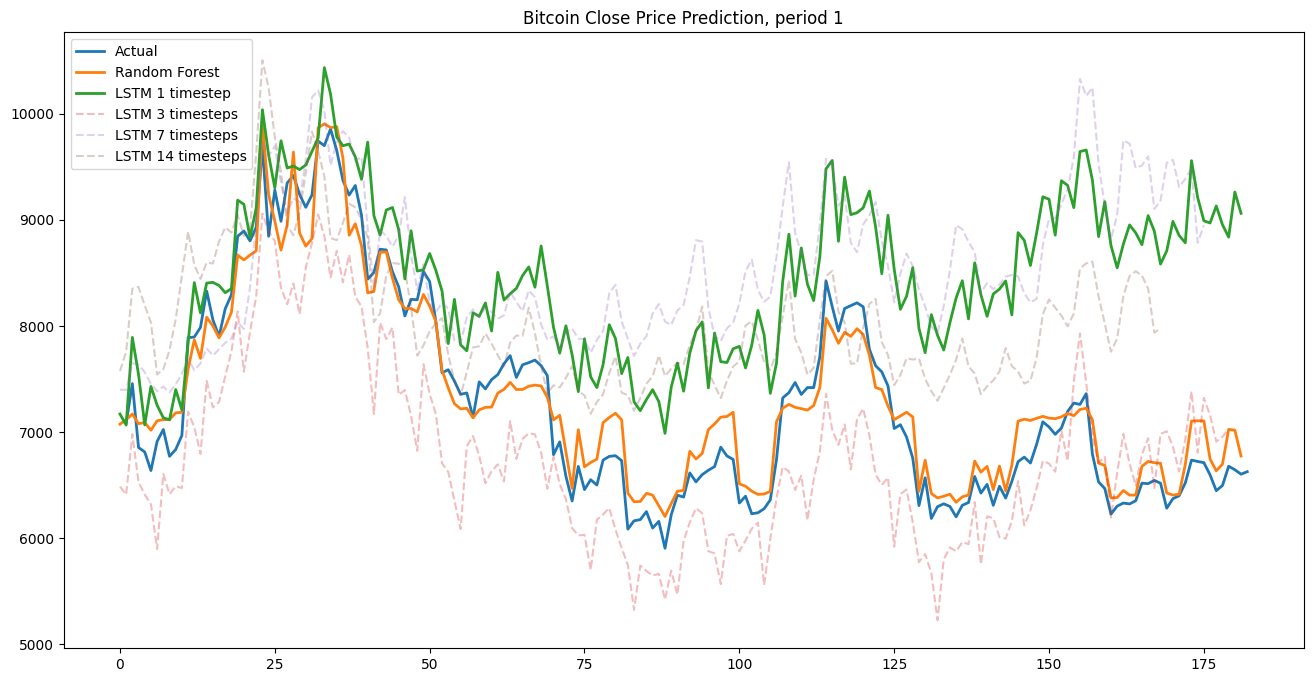

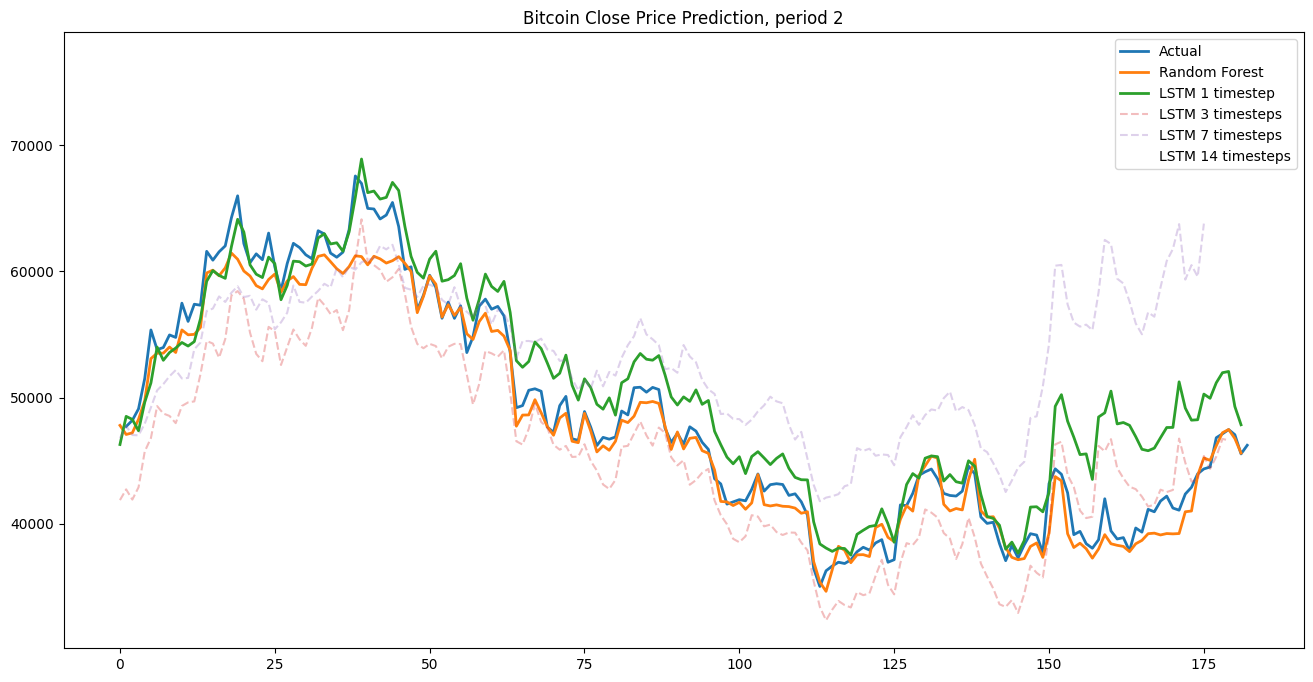

==================================================RMSE==================================================
RMSE RF p1:  329.7287414834731
RMSE LSTM 1 timestep p1:  1429.2611678205672
RMSE LSTM 3 timesteps p1:  785.8683695429299
RMSE LSTM 7 timesteps p1:  1707.6328070488685
RMSE LSTM 14 timesteps p1:  1106.4395662575098
RMSE RF p2:  2184.500651109441
RMSE LSTM 1 timestep p2:  3862.1023055979294
RMSE LSTM 3 timesteps p2:  5069.233607957645
RMSE LSTM 7 timesteps p2:  8956.01002323205
RMSE LSTM 14 timesteps p2:  15615.282780681739
==================================================MAPE==================================================
MAPE RF p1:  0.0349186244596753
MAPE LSTM 1 timestep p1:  0.17721575961286412
MAPE LSTM 3 timesteps p1:  0.08955592354090838
MAPE LSTM 7 timesteps p1:  0.21686637658719718
MAPE LSTM 14 timesteps p1:  0.1395843790232971
MAPE RF p2:  0.03457120726760721
MAPE LSTM 1 timestep p2:  0.0682924333721246
MAPE LSTM 3 timesteps p2:  0.0828136740570225
MAPE LSTM 7 timesteps

In [16]:
# Plot
plt.figure(figsize=(16, 8))
plt.title('Bitcoin Close Price Prediction, period 1')
plt.plot(Y_test_RF_p1, label='Actual', linewidth=2)
plt.plot(RF_p1_results[0], label='Random Forest', linewidth=2)
plt.plot(LSTM_l1_p1_results[0], label='LSTM 1 timestep', linewidth=2)
plt.plot(LSTM_l3_p1_results[0], label='LSTM 3 timesteps', alpha=0.3, linestyle = '--')
plt.plot(LSTM_l7_p1_results[0], label='LSTM 7 timesteps', alpha=0.3, linestyle = '--')
plt.plot(LSTM_l14_p1_results[0], label='LSTM 14 timesteps', alpha=0.3, linestyle = '--')
plt.legend()
plt.show()

plt.figure(figsize=(16, 8))
plt.title('Bitcoin Close Price Prediction, period 2')
plt.plot(Y_test_RF_p2, label='Actual', linewidth=2)
plt.plot(RF_p2_results[0], label='Random Forest', linewidth=2)
plt.plot(LSTM_l1_p2_results[0], label='LSTM 1 timestep', linewidth=2)
plt.plot(LSTM_l3_p2_results[0], label='LSTM 3 timesteps', alpha=0.3, linestyle = '--')
plt.plot(LSTM_l7_p2_results[0], label='LSTM 7 timesteps', alpha=0.3, linestyle = '--')
plt.plot(LSTM_l14_p2_results[0], label='LSTM 14 timesteps', alpha=0., linestyle = '--')
plt.legend()
plt.show()


# RMSE
print("="*50 + "RMSE" + "="*50)
print("RMSE RF p1: ", root_mean_squared_error(Y_test_RF_p1, RF_p1_results[0]))
print("RMSE LSTM 1 timestep p1: ", root_mean_squared_error(Y_test_LSTM_l1_p1, LSTM_l1_p1_results[0]))
print("RMSE LSTM 3 timesteps p1: ", root_mean_squared_error(Y_test_LSTM_l3_p1, LSTM_l3_p1_results[0]))
print("RMSE LSTM 7 timesteps p1: ", root_mean_squared_error(Y_test_LSTM_l7_p1, LSTM_l7_p1_results[0]))
print("RMSE LSTM 14 timesteps p1: ", root_mean_squared_error(Y_test_LSTM_l14_p1, LSTM_l14_p1_results[0]))

print("RMSE RF p2: ", root_mean_squared_error(Y_test_RF_p2, RF_p2_results[0]))
print("RMSE LSTM 1 timestep p2: ", root_mean_squared_error(Y_test_LSTM_l1_p2, LSTM_l1_p2_results[0]))
print("RMSE LSTM 3 timesteps p2: ", root_mean_squared_error(Y_test_LSTM_l3_p2, LSTM_l3_p2_results[0]))
print("RMSE LSTM 7 timesteps p2: ", root_mean_squared_error(Y_test_LSTM_l7_p2, LSTM_l7_p2_results[0]))
print("RMSE LSTM 14 timesteps p2: ", root_mean_squared_error(Y_test_LSTM_l14_p2, LSTM_l14_p2_results[0]))

# MAPE
print("="*50 + "MAPE" + "="*50)
print("MAPE RF p1: ", mean_absolute_percentage_error(Y_test_RF_p1, RF_p1_results[0]))
print("MAPE LSTM 1 timestep p1: ", mean_absolute_percentage_error(Y_test_LSTM_l1_p1, LSTM_l1_p1_results[0]))
print("MAPE LSTM 3 timesteps p1: ", mean_absolute_percentage_error(Y_test_LSTM_l3_p1, LSTM_l3_p1_results[0]))
print("MAPE LSTM 7 timesteps p1: ", mean_absolute_percentage_error(Y_test_LSTM_l7_p1, LSTM_l7_p1_results[0]))
print("MAPE LSTM 14 timesteps p1: ", mean_absolute_percentage_error(Y_test_LSTM_l14_p1, LSTM_l14_p1_results[0]))

print("MAPE RF p2: ", mean_absolute_percentage_error(Y_test_RF_p2, RF_p2_results[0]))
print("MAPE LSTM 1 timestep p2: ", mean_absolute_percentage_error(Y_test_LSTM_l1_p2, LSTM_l1_p2_results[0]))
print("MAPE LSTM 3 timesteps p2: ", mean_absolute_percentage_error(Y_test_LSTM_l3_p2, LSTM_l3_p2_results[0]))
print("MAPE LSTM 7 timesteps p2: ", mean_absolute_percentage_error(Y_test_LSTM_l7_p2, LSTM_l7_p2_results[0]))
print("MAPE LSTM 14 timesteps p2: ", mean_absolute_percentage_error(Y_test_LSTM_l14_p2, LSTM_l14_p2_results[0]))


# DA
print("="*50 + "DA" + "="*50)
print("DA RF p1: ", directional_accuracy(Y_test_RF_p1, RF_p1_results[0]))
print("DA LSTM 1 timestep p1: ", directional_accuracy(Y_test_LSTM_l1_p1, LSTM_l1_p1_results[0]))
print("DA LSTM 3 timesteps p1: ", directional_accuracy(Y_test_LSTM_l3_p1, LSTM_l3_p1_results[0]))
print("DA LSTM 7 timesteps p1: ", directional_accuracy(Y_test_LSTM_l7_p1, LSTM_l7_p1_results[0]))
print("DA LSTM 14 timesteps p1: ", directional_accuracy(Y_test_LSTM_l14_p1, LSTM_l14_p1_results[0]))

print("DA RF p2: ", directional_accuracy(Y_test_RF_p2, RF_p2_results[0]))
print("DA LSTM 1 timestep p2: ", directional_accuracy(Y_test_LSTM_l1_p2, LSTM_l1_p2_results[0]))
print("DA LSTM 3 timesteps p2: ", directional_accuracy(Y_test_LSTM_l3_p2, LSTM_l3_p2_results[0]))
print("DA LSTM 7 timesteps p2: ", directional_accuracy(Y_test_LSTM_l7_p2, LSTM_l7_p2_results[0]))
print("DA LSTM 14 timesteps p2: ", directional_accuracy(Y_test_LSTM_l14_p2, LSTM_l14_p2_results[0]))
